Most of the data points come from the year 2021.
So the classifier could overestimate the number of crimes owing to the fact that the number of crimes had increased in 2021 compared to previous years.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("seaborn")

In [3]:
file_path = "/content/NYPD_Complaint_Data_Current__Year_To_Date_.csv"
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96734 entries, 0 to 96733
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CMPLNT_NUM                96734 non-null  int64  
 1   ADDR_PCT_CD               96734 non-null  int64  
 2   BORO_NM                   96632 non-null  object 
 3   CMPLNT_FR_DT              96734 non-null  object 
 4   CMPLNT_FR_TM              96734 non-null  object 
 5   CMPLNT_TO_DT              88039 non-null  object 
 6   CMPLNT_TO_TM              88067 non-null  object 
 7   CRM_ATPT_CPTD_CD          96682 non-null  object 
 8   HADEVELOPT                395 non-null    object 
 9   HOUSING_PSA               7868 non-null   float64
 10  JURISDICTION_CODE         96646 non-null  float64
 11  JURIS_DESC                96734 non-null  object 
 12  KY_CD                     96734 non-null  int64  
 13  LAW_CAT_CD                96734 non-null  object 
 14  LOC_OF

In [5]:
# Remove duplicate rows (if any) [No duplicate rows here].
df.drop_duplicates(inplace=True)

In [6]:
# Age filter.
df = df[(df["VIC_AGE_GROUP"] == "25-44") | (df["VIC_AGE_GROUP"] == "18-24")]

# Gender filter.
df = df[df["VIC_SEX"] == "F"]

In [7]:
# Redundant column.
df.drop("Lat_Lon", axis=1, inplace=True)

In [8]:
df

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
5,588148056,115,QUEENS,03/24/2021,18:06:00,03/24/2021,18:10:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,347,MISDEMEANOR,NaN,INTOXICATED & IMPAIRED DRIVING,NaN,PATROL BORO QUEENS NORTH,905.0,"INTOXICATED DRIVING,ALCOHOL",STREET,03/24/2021,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,F,1020151,216992,40.762205,-73.870405,POINT (-73.870405222 40.762204702000076)
9,676953815,34,MANHATTAN,03/18/2021,08:30:00,03/22/2021,08:05:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/22/2021,NaN,UNKNOWN,UNKNOWN,U,NaN,25-44,BLACK HISPANIC,F,1005947,254944,40.866419,-73.921556,POINT (-73.92155642099993 40.866418569000075)
10,108453915,44,BRONX,03/21/2021,09:30:00,03/21/2021,09:40:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,NaN,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,03/21/2021,NaN,UNKNOWN,UNKNOWN,F,NaN,25-44,BLACK,F,1003954,242258,40.831604,-73.928799,POINT (-73.92879934599993 40.83160392600007)
20,552198387,113,NaN,03/10/2021,09:00:00,NaN,NaN,COMPLETED,NaN,NaN,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,NaN,03/10/2021,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,F,1043820,183008,40.668799,-73.785265,POINT (-73.785265338 40.66879922900005)
31,656162044,47,BRONX,03/03/2021,00:50:00,03/03/2021,01:15:00,ATTEMPTED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,INSIDE,FELONY ASSAULT,NaN,PATROL BORO BRONX,109.0,"ASSAULT 2,1,UNCLASSIFIED",FAST FOOD,03/03/2021,NaN,UNKNOWN,BLACK,M,NaN,18-24,BLACK,F,1027838,259797,40.879658,-73.842379,POINT (-73.84237853899998 40.879657598000044)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,449562213,42,BRONX,01/05/2021,04:05:00,01/05/2021,04:10:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,121,FELONY,INSIDE,CRIMINAL MISCHIEF & RELATED OF,NaN,PATROL BORO BRONX,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",RESIDENCE - APT. HOUSE,01/05/2021,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,1010027,240720,40.827367,-73.906860,POINT (-73.90685995799998 40.82736692100008)
96719,644757114,23,MANHATTAN,01/05/2021,21:30:00,01/05/2021,21:50:00,COMPLETED,NaN,676.0,2.0,N.Y. HOUSING POLICE,106,FELONY,INSIDE,FELONY ASSAULT,NaN,PATROL BORO MAN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,01/06/2021,NaN,UNKNOWN,UNKNOWN,U,NaN,25-44,WHITE HISPANIC,F,1000866,226632,40.788721,-73.939997,POINT (-73.93999677399995 40.788721243000055)
96723,449084655,101,QUEENS,01/02/2021,07:30:00,01/03/2021,09:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,NaN,PATROL BORO QUEENS SOUTH,321.0,"LARCENY,PETIT FROM AUTO",RESIDENCE-HOUSE,01/03/2021,NaN,NaN,NaN,NaN,NaN,25-44,AMERICAN INDIAN/ALASKAN NATIVE,F,1052753,160863,40.607952,-73.753289,POINT (-73.75328891799995 40.607951554000074)
96727,225498392,48,BRONX,01/05/2021,18:39:00,01/05/2021,18:43:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,109,FELONY,FRONT OF,GRAND LARCENY,NaN,PATROL BORO BRONX,409.0,"LARCENY,GRAND BY EXTORTION",RESIDENCE - APT. HOUSE,01/05/2021,NaN,NaN,NaN,NaN,NaN,25-44,BLACK HISPANIC,F,1015010,250473,40.854120,-73.888810,POINT (-73.88880988799998 40.854120099000056)


In [9]:
# Safety check for no null values in `CMPLNT_NUM` since it is a primary identifier
df = df[df["CMPLNT_NUM"].notnull()]
assert not df["CMPLNT_NUM"].isnull().values.any()

In [10]:
# We do not need uncompleted crimes for analysis
df.dropna(axis=0, subset=["CRM_ATPT_CPTD_CD"], inplace=True)

In [11]:
# Important to know the type of crime, we want to preserve them.
df = df[df["LAW_CAT_CD"].notnull()]

In [12]:
# Instances of null borough and precinct simultaneously can be removed.
mask = ~(df["BORO_NM"].isnull() & df["ADDR_PCT_CD"].isnull())
df = df[mask]

In [13]:
print(f'HADEVELOPT has {(df["HADEVELOPT"].isna().sum() / len(df["HADEVELOPT"]) * 100)}% null values')
print(f'PARKS_NM has {(df["PARKS_NM"].isna().sum() / len(df["PARKS_NM"]) * 100)}% null values')

HADEVELOPT has 99.3402028265385% null values
PARKS_NM has 99.84523276178064% null values


In [14]:
# Getting rid of HADEVELOPT and PARKS_NM since it has more than 99% null values.
del df["HADEVELOPT"], df["PARKS_NM"]

In [15]:
df = df[df["JURIS_DESC"].notnull()]

In [16]:
# It would be important to know the location of crime.
latlon_mask = ~(df["Latitude"].isnull() & df["Longitude"].isnull())
df = df[latlon_mask]

In [17]:
print(f'HOUSING_PSA has {(df["HOUSING_PSA"].isna().sum() / len(df["HOUSING_PSA"]) * 100)}% null values')
del df["HOUSING_PSA"] # Removing this column since it has > 90% null values

HOUSING_PSA has 86.91809554840549% null values


In [18]:
# No need of coordinates in the New York State Plane Coordinate System for our analysis
del df["X_COORD_CD"], df["Y_COORD_CD"]

In [19]:
print(f'STATION_NAME has {(df["STATION_NAME"].isna().sum() / len(df["STATION_NAME"]) * 100)}% null values')
del df["STATION_NAME"]

STATION_NAME has 98.59080356779212% null values


In [20]:
print(f'TRANSIT_DISTRICT has {(df["TRANSIT_DISTRICT"].isna().sum() / len(df["TRANSIT_DISTRICT"]) * 100)}% null values')
del df["TRANSIT_DISTRICT"]

TRANSIT_DISTRICT has 98.59080356779212% null values


In [21]:
# We would not be focusing on the details about the suspect but about the victim
df.drop(["SUSP_AGE_GROUP", "SUSP_RACE", "SUSP_SEX"], axis=1, inplace=True)

In [22]:
# Description:
"""
This is the filtered version of the original dataset:

- Contains instances of only females with age group 18-44, the main focus of the design.
- Only completed crimes are present. For our analysis, including any aborted crimes 
  might result in false-positive cases of successful crimes.
- Least number of irrelevant columns are removed (mainly due to too many null values).

"""
df

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,New Georeferenced Column
5,588148056,115,QUEENS,03/24/2021,18:06:00,03/24/2021,18:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,347,MISDEMEANOR,NaN,INTOXICATED & IMPAIRED DRIVING,PATROL BORO QUEENS NORTH,905.0,"INTOXICATED DRIVING,ALCOHOL",STREET,03/24/2021,25-44,BLACK,F,40.762205,-73.870405,POINT (-73.870405222 40.762204702000076)
9,676953815,34,MANHATTAN,03/18/2021,08:30:00,03/22/2021,08:05:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/22/2021,25-44,BLACK HISPANIC,F,40.866419,-73.921556,POINT (-73.92155642099993 40.866418569000075)
10,108453915,44,BRONX,03/21/2021,09:30:00,03/21/2021,09:40:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,03/21/2021,25-44,BLACK,F,40.831604,-73.928799,POINT (-73.92879934599993 40.83160392600007)
20,552198387,113,NaN,03/10/2021,09:00:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,03/10/2021,25-44,BLACK,F,40.668799,-73.785265,POINT (-73.785265338 40.66879922900005)
31,656162044,47,BRONX,03/03/2021,00:50:00,03/03/2021,01:15:00,ATTEMPTED,0.0,N.Y. POLICE DEPT,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO BRONX,109.0,"ASSAULT 2,1,UNCLASSIFIED",FAST FOOD,03/03/2021,18-24,BLACK,F,40.879658,-73.842379,POINT (-73.84237853899998 40.879657598000044)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,449562213,42,BRONX,01/05/2021,04:05:00,01/05/2021,04:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,121,FELONY,INSIDE,CRIMINAL MISCHIEF & RELATED OF,PATROL BORO BRONX,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",RESIDENCE - APT. HOUSE,01/05/2021,25-44,WHITE HISPANIC,F,40.827367,-73.906860,POINT (-73.90685995799998 40.82736692100008)
96719,644757114,23,MANHATTAN,01/05/2021,21:30:00,01/05/2021,21:50:00,COMPLETED,2.0,N.Y. HOUSING POLICE,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO MAN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,01/06/2021,25-44,WHITE HISPANIC,F,40.788721,-73.939997,POINT (-73.93999677399995 40.788721243000055)
96723,449084655,101,QUEENS,01/02/2021,07:30:00,01/03/2021,09:00:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO QUEENS SOUTH,321.0,"LARCENY,PETIT FROM AUTO",RESIDENCE-HOUSE,01/03/2021,25-44,AMERICAN INDIAN/ALASKAN NATIVE,F,40.607952,-73.753289,POINT (-73.75328891799995 40.607951554000074)
96727,225498392,48,BRONX,01/05/2021,18:39:00,01/05/2021,18:43:00,COMPLETED,0.0,N.Y. POLICE DEPT,109,FELONY,FRONT OF,GRAND LARCENY,PATROL BORO BRONX,409.0,"LARCENY,GRAND BY EXTORTION",RESIDENCE - APT. HOUSE,01/05/2021,25-44,BLACK HISPANIC,F,40.854120,-73.888810,POINT (-73.88880988799998 40.854120099000056)



Maximum no. of felony crimes is concerned with the race black with females aged between 15-44 and the count is 44



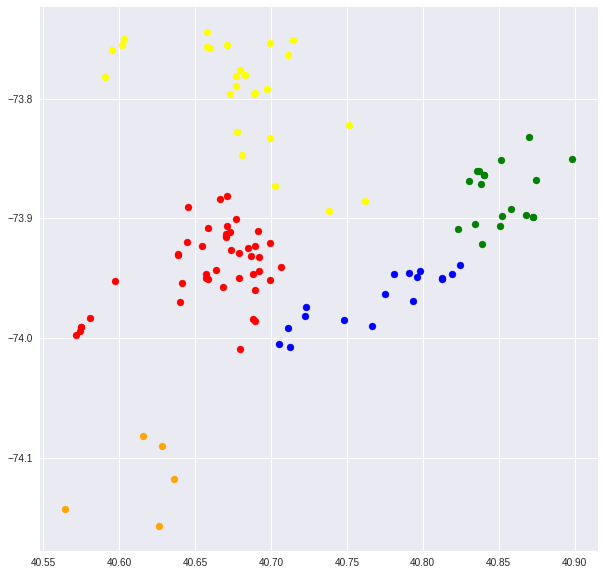

In [23]:
"""
Maximum no. of crimes seems to be on females with race black and age between 15-44 in the Brooklyn borough

"""
black_df = df[(df["VIC_RACE"] == "BLACK") & (df["LAW_CAT_CD"] == "FELONY") & ((df["CMPLNT_FR_TM"] > "17:00:00") & (df["CMPLNT_FR_TM"] < "18:00:00"))]

brook = black_df[black_df["BORO_NM"] == "BROOKLYN"]
manh = black_df[black_df["BORO_NM"] == "MANHATTAN"]
bronx = black_df[black_df["BORO_NM"] == "BRONX"]
qu = black_df[black_df["BORO_NM"] == "QUEENS"]
state = black_df[black_df["BORO_NM"] == "STATEN ISLAND"]

dfs = [brook, manh, bronx, qu, state]
df_lens = [len(df_) for df_ in dfs]

print(f"\nMaximum no. of felony crimes is concerned with the race black with females aged between 15-44 and the count is {max(df_lens)}\n")

fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot()

axes.scatter(brook["Latitude"], brook["Longitude"], c="red")
axes.scatter(manh["Latitude"], manh["Longitude"], c="blue")
axes.scatter(bronx["Latitude"], bronx["Longitude"], c="green")
axes.scatter(qu["Latitude"], qu["Longitude"], c="yellow")
axes.scatter(state["Latitude"], state["Longitude"], c="orange")

In [24]:
df

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Latitude,Longitude,New Georeferenced Column
5,588148056,115,QUEENS,03/24/2021,18:06:00,03/24/2021,18:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,347,MISDEMEANOR,NaN,INTOXICATED & IMPAIRED DRIVING,PATROL BORO QUEENS NORTH,905.0,"INTOXICATED DRIVING,ALCOHOL",STREET,03/24/2021,25-44,BLACK,F,40.762205,-73.870405,POINT (-73.870405222 40.762204702000076)
9,676953815,34,MANHATTAN,03/18/2021,08:30:00,03/22/2021,08:05:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/22/2021,25-44,BLACK HISPANIC,F,40.866419,-73.921556,POINT (-73.92155642099993 40.866418569000075)
10,108453915,44,BRONX,03/21/2021,09:30:00,03/21/2021,09:40:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,FRONT OF,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,03/21/2021,25-44,BLACK,F,40.831604,-73.928799,POINT (-73.92879934599993 40.83160392600007)
20,552198387,113,NaN,03/10/2021,09:00:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,101,FELONY,OUTSIDE,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,NaN,NaN,03/10/2021,25-44,BLACK,F,40.668799,-73.785265,POINT (-73.785265338 40.66879922900005)
31,656162044,47,BRONX,03/03/2021,00:50:00,03/03/2021,01:15:00,ATTEMPTED,0.0,N.Y. POLICE DEPT,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO BRONX,109.0,"ASSAULT 2,1,UNCLASSIFIED",FAST FOOD,03/03/2021,18-24,BLACK,F,40.879658,-73.842379,POINT (-73.84237853899998 40.879657598000044)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96714,449562213,42,BRONX,01/05/2021,04:05:00,01/05/2021,04:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,121,FELONY,INSIDE,CRIMINAL MISCHIEF & RELATED OF,PATROL BORO BRONX,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",RESIDENCE - APT. HOUSE,01/05/2021,25-44,WHITE HISPANIC,F,40.827367,-73.906860,POINT (-73.90685995799998 40.82736692100008)
96719,644757114,23,MANHATTAN,01/05/2021,21:30:00,01/05/2021,21:50:00,COMPLETED,2.0,N.Y. HOUSING POLICE,106,FELONY,INSIDE,FELONY ASSAULT,PATROL BORO MAN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,01/06/2021,25-44,WHITE HISPANIC,F,40.788721,-73.939997,POINT (-73.93999677399995 40.788721243000055)
96723,449084655,101,QUEENS,01/02/2021,07:30:00,01/03/2021,09:00:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,FRONT OF,PETIT LARCENY,PATROL BORO QUEENS SOUTH,321.0,"LARCENY,PETIT FROM AUTO",RESIDENCE-HOUSE,01/03/2021,25-44,AMERICAN INDIAN/ALASKAN NATIVE,F,40.607952,-73.753289,POINT (-73.75328891799995 40.607951554000074)
96727,225498392,48,BRONX,01/05/2021,18:39:00,01/05/2021,18:43:00,COMPLETED,0.0,N.Y. POLICE DEPT,109,FELONY,FRONT OF,GRAND LARCENY,PATROL BORO BRONX,409.0,"LARCENY,GRAND BY EXTORTION",RESIDENCE - APT. HOUSE,01/05/2021,25-44,BLACK HISPANIC,F,40.854120,-73.888810,POINT (-73.88880988799998 40.854120099000056)


In [25]:
df.to_csv("NYC_Analysis.csv")

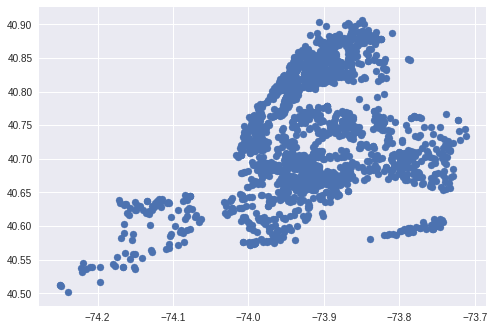

In [26]:
"""
Example plot of completed crimes that started after 5pm and ended before 6pm

"""
df_5_to_6 = df[(df["CMPLNT_FR_TM"] > "17:00:00") & (df["CMPLNT_TO_TM"] < "18:00:00")]
plt.scatter(df_5_to_6["Longitude"], df_5_to_6["Latitude"])

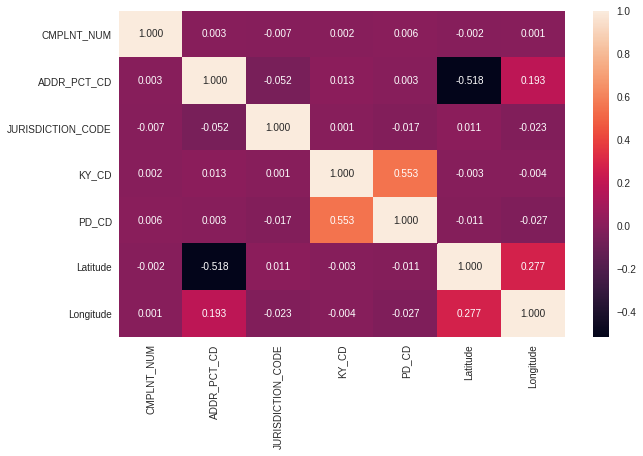

In [27]:
# Correlation analysis
"""
There isn't significant correlation between the numerical columns except a few.

"""
corr = df.corr()

fig, axes = plt.subplots(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".3f")

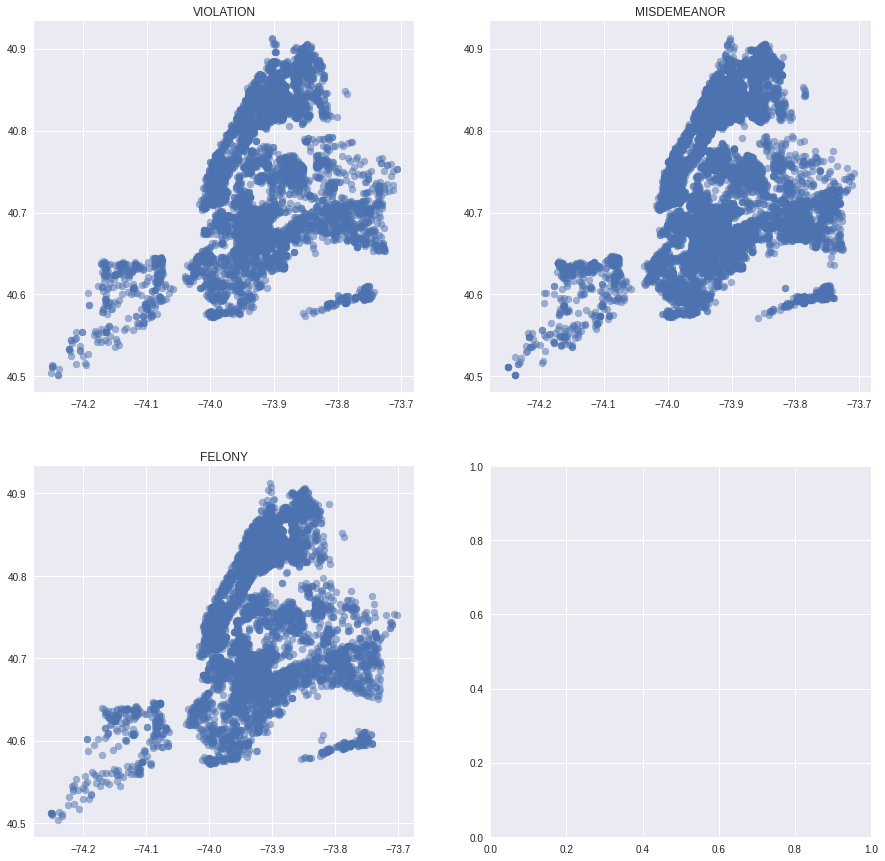

In [28]:
# Analysis of type of crimes and their location.
"""
Each point for each type of crime shows the location of that crime.

- The spread of crimes is similar across all the types. This suggests
  crimes are almost equivalently spread across NY

"""

violation = df[df["LAW_CAT_CD"] == "VIOLATION"] # Mild
misdemeanor = df[df["LAW_CAT_CD"] == "MISDEMEANOR"] # Intermediate
felony = df[df["LAW_CAT_CD"] == "FELONY"] # High danger

colors = np.random.rand(len(df['Longitude']))

fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

axes[0, 0].set_title("VIOLATION")
axes[0, 1].set_title("MISDEMEANOR")
axes[1, 0].set_title("FELONY")

axes[0, 0].scatter(violation['Longitude'], violation['Latitude'], alpha=0.5)
axes[0, 1].scatter(misdemeanor['Longitude'], misdemeanor['Latitude'], alpha=0.5)
axes[1, 0].scatter(felony['Longitude'], felony['Latitude'], alpha=0.5)

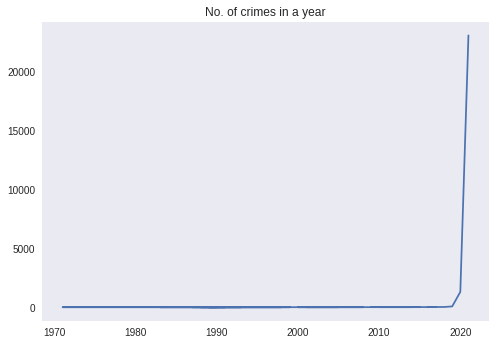

In [29]:
"""
The dataset has most number of data points from the year 2021 where the crime 
rate had significantly increased compared to the previous years.

"""
years = df["CMPLNT_FR_DT"].map(lambda dt: int(str(dt).split('/')[2]))
plt.plot(years.value_counts())
plt.grid(False)
plt.title("No. of crimes in a year")

plt.show()